In [1]:
!pip install pandas
!pip install quandl
!pip install scikit-learn

In [2]:
import pandas as pd
import quandl
import math,datetime
import numpy as np
from sklearn import preprocessing,svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot  as plt
from matplotlib import style
import pickle

In [3]:
df = quandl.get('WIKI/GOOGL')
style.use('ggplot')
print(df.head())

              Open    High     Low    Close      Volume  Ex-Dividend  \
Date                                                                   
2004-08-19  100.01  104.06   95.96  100.335  44659000.0          0.0   
2004-08-20  101.01  109.08  100.50  108.310  22834300.0          0.0   
2004-08-23  110.76  113.48  109.05  109.400  18256100.0          0.0   
2004-08-24  111.24  111.60  103.57  104.870  15247300.0          0.0   
2004-08-25  104.76  108.00  103.88  106.000   9188600.0          0.0   

            Split Ratio  Adj. Open  Adj. High   Adj. Low  Adj. Close  \
Date                                                                   
2004-08-19          1.0  50.159839  52.191109  48.128568   50.322842   
2004-08-20          1.0  50.661387  54.708881  50.405597   54.322689   
2004-08-23          1.0  55.551482  56.915693  54.693835   54.869377   
2004-08-24          1.0  55.792225  55.972783  51.945350   52.597363   
2004-08-25          1.0  52.542193  54.167209  52.100830   53.1

In [4]:
df = df[['Adj. Open','Adj. High','Adj. Low','Adj. Close','Adj. Volume']]

In [5]:
df['HL_PCT'] = (df['Adj. High']-df['Adj. Close']) / df['Adj. Close'] *100.0
df['PCT_change'] = (df['Adj. Close']-df['Adj. Open']) / df['Adj. Open'] *100.0

In [6]:
df = df[['Adj. Close','HL_PCT','PCT_change','Adj. Volume']]

In [7]:
print(df.head())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume
Date                                                     
2004-08-19   50.322842  3.712563    0.324968   44659000.0
2004-08-20   54.322689  0.710922    7.227007   22834300.0
2004-08-23   54.869377  3.729433   -1.227880   18256100.0
2004-08-24   52.597363  6.417469   -5.726357   15247300.0
2004-08-25   53.164113  1.886792    1.183658    9188600.0


In [8]:
forecast_col = 'Adj. Close'
df.fillna(-99999,inplace=True)


forecast_out = int(math.ceil(0.01*len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)
print(df.head())



            Adj. Close    HL_PCT  PCT_change  Adj. Volume      label
Date                                                                
2004-08-19   50.322842  3.712563    0.324968   44659000.0  69.078238
2004-08-20   54.322689  0.710922    7.227007   22834300.0  67.839414
2004-08-23   54.869377  3.729433   -1.227880   18256100.0  68.912727
2004-08-24   52.597363  6.417469   -5.726357   15247300.0  70.668146
2004-08-25   53.164113  1.886792    1.183658    9188600.0  71.219849


In [9]:

X = np.array(df.drop(['label'],1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out:]



/tmp/ipykernel_6316/3308390000.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(df.drop(['label'],1))


In [10]:
df.dropna(inplace=True)
y = np.array(df['label'])

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [12]:
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train,y_train)

with open('linearregression.pickle','wb') as f:
    pickle.dump(clf,f)
    

pickle_in = open('linearregression.pickle','rb')
clf = pickle.load(pickle_in)
accuracy = clf.score(X_test,y_test)
# print(accuracy)

In [13]:
forecast_set = clf.predict(X_lately)
print(forecast_set,accuracy,forecast_out)

[1101.79327897 1073.01723775 1020.07730739 1060.9952649  1073.3027509
 1073.43196084 1091.93392091 1111.33155347 1114.55800927 1122.47647065
 1131.80461409 1129.46200436 1148.76338033 1164.40698091 1136.37405353
 1122.53634851 1088.47357302 1103.0122001  1114.07394158 1121.3240584
 1134.9056478  1149.7407701  1181.19869659 1185.85900731 1157.99747402
 1168.71413964 1170.54684242 1153.59313078 1118.94079221 1115.19629679
 1112.84714026 1070.39843811 1042.51206364 1073.13442369 1021.67851892] 0.9774886826103105 35


In [14]:
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

In [15]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    # Use .loc for label-based indexing to add new rows
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

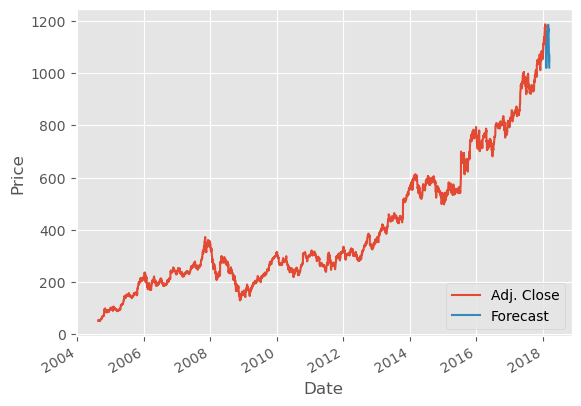

In [17]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()